In [2]:
pip install hpelm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 6.6 MB/s eta 0:00:00


In [3]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=0dd9f49cca1ea434214c1f0e90e7765005358f019ae09ff12bb59e32f36aab6a
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [5]:
pip install mapie

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 kB 4.5 MB/s eta 0:00:00


In [4]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 3.1 MB/s eta 0:00:00


✅ Data shape: (27531, 18)

📘 X_train_scaled DataFrame:
        BVP       EDA      TEMP      AccX      AccY      AccZ        HR  \
0 -0.236276 -0.708252 -1.023767  1.591055 -1.029676  1.056229 -0.514252   
1  1.095257  0.592021  0.103095 -1.077047  0.968156 -0.320707  1.334348   
2  0.127289  0.599888  1.245979 -1.264282 -0.167866 -0.891632 -0.769734   
3 -0.525128 -0.668819  0.722602 -0.562150 -1.108023  0.015131  0.376534   
4  0.985385 -0.682799  0.017646 -1.123855 -0.324559 -0.555793  0.192937   

      Delta     Theta    Alpha1    Alpha2     Beta1     Beta2    Gamma1  \
0  1.259641 -0.371131  0.676199 -0.566670  0.575726 -0.635747 -0.516289   
1 -0.646587 -0.381736  1.718746  0.115653  0.508169 -0.258007 -0.336352   
2 -0.613363  0.588219 -0.732973 -0.614810  0.875468  1.833919  4.914687   
3 -0.047946 -0.257798  1.650485 -0.696863  0.262133  0.317078  0.218833   
4  0.200207  0.346404  0.337054 -0.298132 -0.712601  1.091021 -0.577340   

     Gamma2   Attention   Meditation  
0  0

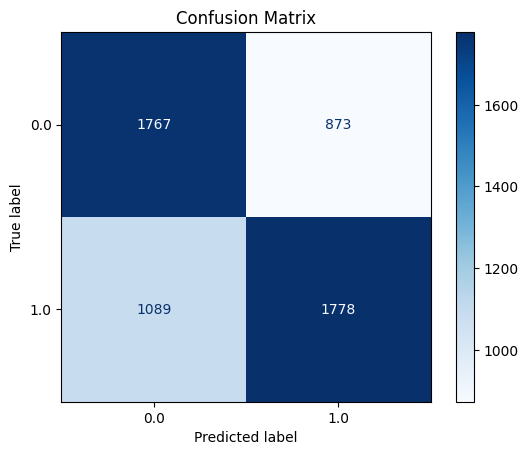

   Sample  Predicted_Class  Uncertainty (1 - max prob)
0       0              0.0                    0.096133
1       1              0.0                    0.431487
2       2              0.0                    0.156547
3       3              1.0                    0.333549
4       4              0.0                    0.415819


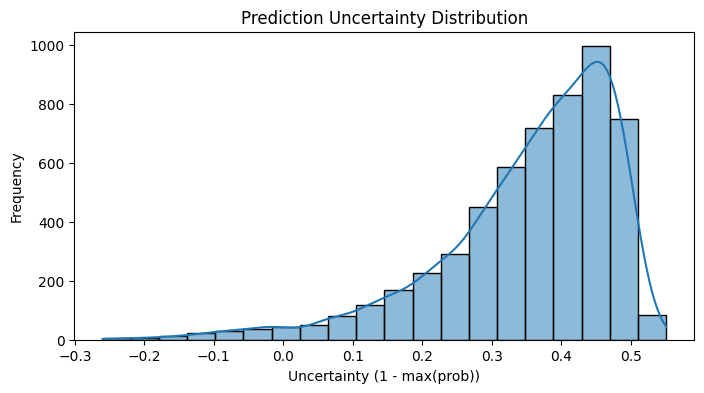

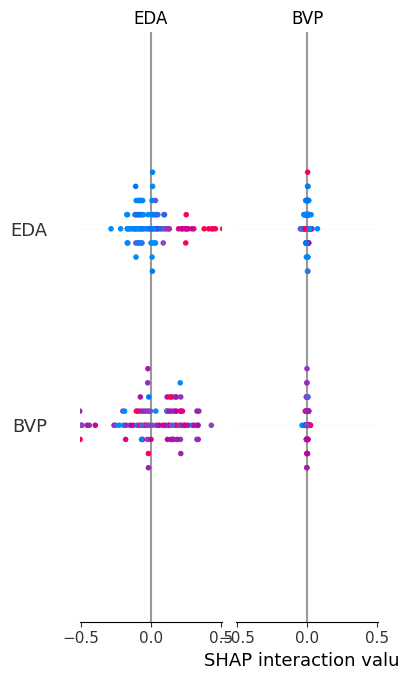

🟡 LIME Explanation for First Sample:
[('EDA <= -0.66', -0.15986626151422031), ('TEMP > 0.75', 0.10514561734687686), ('HR > 0.59', -0.06755790401313326), ('AccZ <= -0.62', -0.041506531236710116), ('-0.05 < AccY <= 0.50', 0.021222496005554026), ('AccX > 0.56', -0.01595285141118195), ('0.02 <  Meditation <= 0.88', -0.012931981184105093), ('-0.38 <  Gamma2 <= 0.23', 0.010323311045925335), ('-0.64 <  Alpha2 <= -0.38', -0.010140781147316272), (' Theta > 0.21', 0.00625297434144247)]
✅ Results saved to 'ELM_Model_Results.xlsx'


In [6]:
# elm_uncertainty_xai.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from lime.lime_tabular import LimeTabularExplainer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, confusion_matrix, classification_report,
    ConfusionMatrixDisplay
)

from hpelm import ELM
import warnings
warnings.filterwarnings("ignore")


def compute_uncertainty(probs):
    """Return uncertainty as 1 - max(probability) for each sample."""
    return 1 - np.max(probs, axis=1)


def main():
    # === Load Dataset ===
    data = pd.read_csv("/content/drive/MyDrive/CODE/Prince Okyere/DOWN/MEFAR_DOWN.csv")  # Update with your actual file path
    data.dropna(inplace=True)
    print("✅ Data shape:", data.shape)

    # === Encode Class Column ===
    label_encoder = LabelEncoder()
    data['class'] = label_encoder.fit_transform(data['class'])
    classes = label_encoder.classes_.astype(str)

    X = data.drop('class', axis=1)
    y = data['class']
    encoder = OneHotEncoder()
    y_encoded = encoder.fit_transform(y.values.reshape(-1, 1)).toarray()

    # === Train/Test Split ===
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
    y_train_class = np.argmax(y_train, axis=1)
    y_test_class = np.argmax(y_test, axis=1)

    # === Scaling ===
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # === ELM Training ===
    elm = ELM(X_train_scaled.shape[1], y_train.shape[1])
    elm.add_neurons(50, "sigm")
    elm.add_neurons(50, "tanh")
    elm.add_neurons(y_train.shape[1], "sigm")
    elm.train(X_train_scaled, y_train)

    y_pred_prob = elm.predict(X_test_scaled)
    y_pred = (y_pred_prob > 0.5).astype(int)
    y_pred_class = np.argmax(y_pred, axis=1)

    # === Convert arrays to DataFrames for inspection ===
    X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
    X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)

    y_pred_class_df = pd.DataFrame({
        "Predicted Class": label_encoder.inverse_transform(y_pred_class)
    })

    y_pred_prob_df = pd.DataFrame(y_pred_prob, columns=[f"Class_{cls}" for cls in label_encoder.classes_])

    # === Print DataFrames (first few rows only) ===
    print("\n📘 X_train_scaled DataFrame:")
    print(X_train_df.head())

    print("\n📗 X_test_scaled DataFrame:")
    print(X_test_df.head())

    print("\n📙 y_pred_class DataFrame:")
    print(y_pred_class_df.head())

    print("\n📕 y_pred_prob DataFrame:")
    print(y_pred_prob_df.head())


    # === Evaluation ===
    acc = accuracy_score(y_test_class, y_pred_class)
    prec = precision_score(y_test_class, y_pred_class, average='weighted')
    rec = recall_score(y_test_class, y_pred_class, average='weighted')
    f1 = f1_score(y_test_class, y_pred_class, average='weighted')
    mcc = matthews_corrcoef(y_test_class, y_pred_class)
    report = classification_report(y_test_class, y_pred_class, target_names=classes)
    cm = confusion_matrix(y_test_class, y_pred_class)

    print("📊 Classification Report:\n", report)

    # === Youden Index (for binary only) ===
    youden_index = np.nan
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp)
        sensitivity = recall_score(y_test_class, y_pred_class)
        youden_index = sensitivity + specificity - 1

    # === Plot Confusion Matrix ===
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes).plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    # === Uncertainty from Max Probabilities ===
    uncertainties = compute_uncertainty(y_pred_prob)
    uncertainty_df = pd.DataFrame({
        "Sample": np.arange(len(uncertainties)),
        "Predicted_Class": label_encoder.inverse_transform(y_pred_class),
        "Uncertainty (1 - max prob)": uncertainties
    })
    print(uncertainty_df.head())

    # === Plot Uncertainty Distribution ===
    plt.figure(figsize=(8, 4))
    sns.histplot(uncertainties, bins=20, kde=True)
    plt.title("Prediction Uncertainty Distribution")
    plt.xlabel("Uncertainty (1 - max(prob))")
    plt.ylabel("Frequency")
    plt.show()

    # === Surrogate Random Forest for XAI ===
    rf = RandomForestClassifier()
    rf.fit(X_train_scaled, y_train_class)

    # === SHAP Summary Plot ===
    explainer = shap.Explainer(rf, X_train_scaled)
    shap_values = explainer(X_test_scaled[:100])
    shap.summary_plot(shap_values, X_test.iloc[:100], show=True)

    # === LIME Explanation ===
    lime_exp = LimeTabularExplainer(X_train_scaled, feature_names=X.columns,
                                    class_names=classes, discretize_continuous=True)
    lime_result = lime_exp.explain_instance(X_test_scaled[0], rf.predict_proba, num_features=10)
    print("🟡 LIME Explanation for First Sample:")
    print(lime_result.as_list())

    # === Save to Excel ===
    results_df = pd.DataFrame({
        "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "MCC", "Youden Index"],
        "Value": [acc, prec, rec, f1, mcc, youden_index]
    })
    results_df.to_excel("ELM_Model_Results.xlsx", index=False)
    print("✅ Results saved to 'ELM_Model_Results.xlsx'")


if __name__ == "__main__":
    main()
